<a href="https://colab.research.google.com/github/Redhoxx/VUT_ML/blob/main/lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPA-MLF, Lab 6 - Feedforward Neural Networks with regularization techniques and hyperparameter tunning

## Exercise 1 - Classification of an images

The goal of this task will be to create Multi-layer perceptron model, that is able to recognize the  CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR10 dataset consist of 60000 images with resolution of 32x32 pixels. There are 10 classes in total - *airplane*, *automobile*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*

These is an example of the dataset:

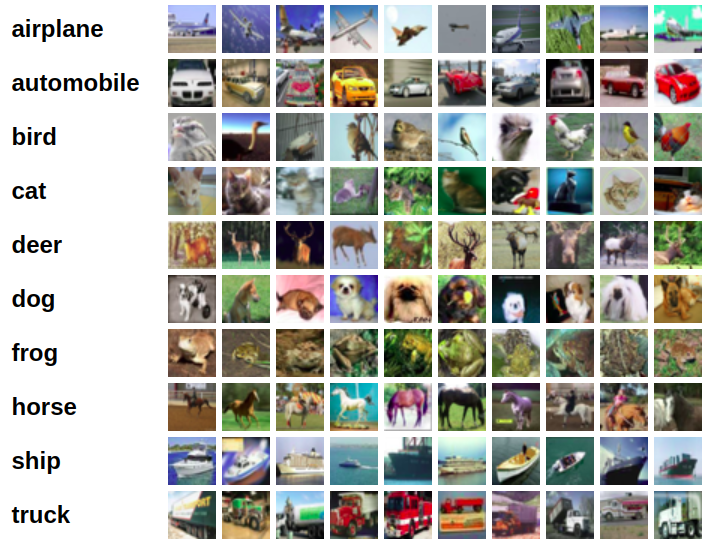

### 0. Import libraries

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

### 1. Load the Dataset
The dataset is already a part of the Keras library, so we can quickly load it using the following command

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


The following numbered labels represent the labels in the dataset:

In [ ]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

### 2. Data Examination

Fistly, lets have a look and the couple of images we have,

In [ ]:
def display_random_images(x_data: np.array, y_data: np.array, count: int = 10) -> None:
  index = np.array(len(x_data))
  selected_ind = np.random.choice(index, count)

  selected_img = x_data[selected_ind]
  selected_labels_encoded = y_data[selected_ind]
  selected_labels = [labels[x[0]] for x in selected_labels_encoded]

  concat_img = np.concatenate(selected_img, axis=1)

  plt.figure(figsize=(20,10))
  plt.imshow(concat_img)

  for id_label, label in enumerate(selected_labels):
    plt.text((32/2) + 32*id_label - len(label), 32*(5/4), label)
  plt.axis('off')
  plt.show()



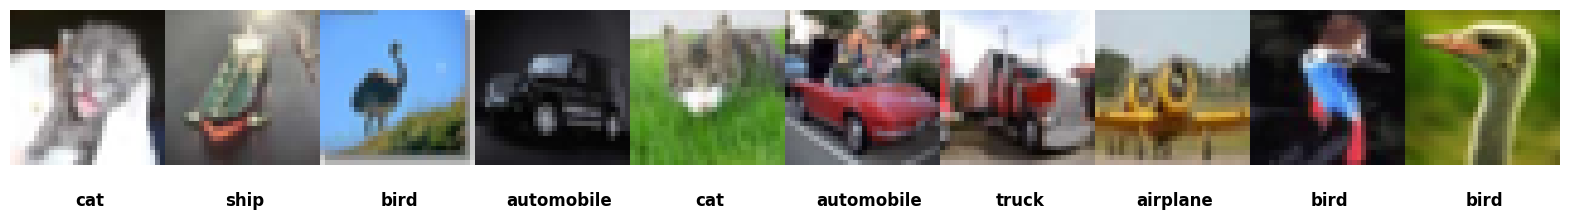

In [ ]:
display_random_images(X_train, y_train)

In [ ]:
#check the shape of image dataset

X_train.shape

(50000, 32, 32, 3)

In our dataset, we have 60000 images with 32x32 resolution. Each image has three channels (R, G, B). We have 50000 images for training and 10000 images for testing. Each channel for each image has values from 0 - 255, where each number represents the pixel intensity.
With the combination of intensities of R, G and B, you can display up to 16,777,216 different colours (256^3)

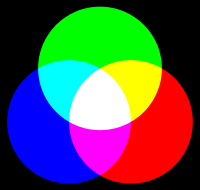

Here you can display each channel separately:

In [ ]:
def display_channels_separately(image: np.array) -> None:

  plt.figure()
  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))


  axs[0].imshow(image[:,:,0],cmap='Reds')
  axs[1].imshow(image[:,:,1],cmap='Blues')
  axs[2].imshow(image[:,:,2],cmap='Greens')

  axs[3].imshow(image)

  plt.show()

<Figure size 640x480 with 0 Axes>

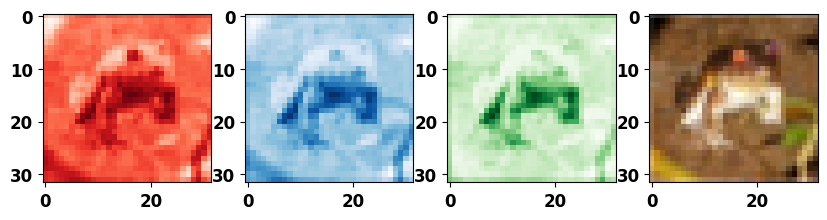

In [ ]:
display_channels_separately(X_train[0])

### 3. Preprocessing of the images

For machine learning purposes, we have to preprocess our images. Firstly we need to scale our images, to scale intensity values from 0-1 (min-max scaling)

In [ ]:
X_train_scaled = X_train.astype('float32') / 255.0

We need to one-hot-encode the labels in our ground truth variable as our second preprocessing.

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=10)

### 4. Define the model architecture

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We will define *the Sequential* model as in our last exercise. This time we will use a different approach to determine the input layers. Instead of specifying the *input_dim* parameter in our first hidden layer, we will create a **Flatten** layer that takes our 32x32x3 image and reshapes it into 1x3072.

We will specify ten neurons in our output layer because we have 10 possible outputs and a **softmax** activation function that returns us a probability distribution over the classes. The class with the highest probability is typically chosen as the predicted class for a given input.

Check the description of our model:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

The next step is to compile our model, we will use *categorical_crossentropy* as a loss function, *stochastic gradient descend* as an optimisation and we will be checking *the accuracy* metric.

In [ ]:
optimizer = SGD(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### 5. Train the model

Our model will be trained in the same way as in our last pc_labs,

In [ ]:
history = model.fit(X_train_scaled, y_train_encoded, epochs=20, batch_size=128, validation_split = 0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1066 - loss: 2.3838 - val_accuracy: 0.1524 - val_loss: 2.2817
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1554 - loss: 2.2777 - val_accuracy: 0.1825 - val_loss: 2.2555
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1822 - loss: 2.2520 - val_accuracy: 0.1981 - val_loss: 2.2328
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2004 - loss: 2.2291 - val_accuracy: 0.2140 - val_loss: 2.2118
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2194 - loss: 2.2096 - val_accuracy: 0.2227 - val_loss: 2.1930
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2272 - loss: 2.1910 - val_accuracy: 0.2319 - val_loss: 2.1758
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2361 - loss: 2.1739 - val_accuracy: 0.2452 - val_loss: 2.1600
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2485 - loss: 2.1562 - val_accurac

### 6. Model evaluation

In [ ]:
X_test = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=10)

In [ ]:
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 2.0301711559295654
Test accuracy: 30.630001425743103 %


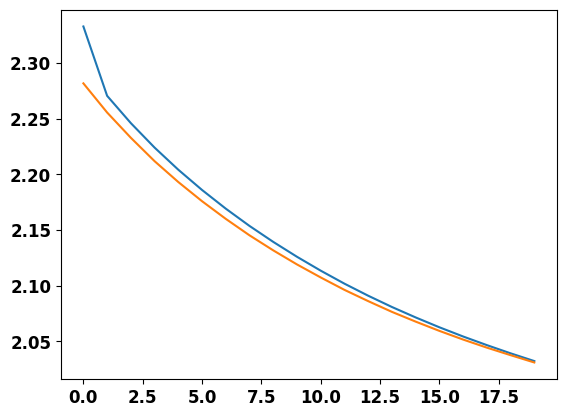

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

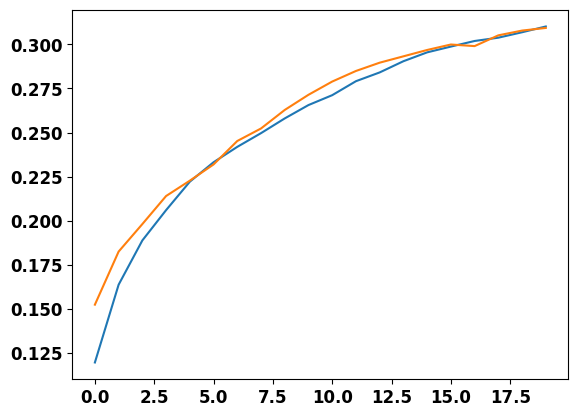

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

As you can see from the evaluation above, we was able to achive approx. 30% of an accuracy. In other word approx. 70% of an images we classified wrongly. That is really bad!

Lets check the best predictions from our model:

In [26]:
def show_the_best_predictions(model, x_test: np.array, y_test: np.array, n_of_pred: int = 10) -> None:
  mapping = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

  predictions = model.predict(x_test)
  y_test = y_test.reshape(1,-1)
  predictions_ind = np.argmax(predictions, axis=1)
  predictions_ind = predictions_ind.reshape(1, -1)

  corect_predictions = np.where(predictions_ind == y_test)

  rows_correct = corect_predictions[1]
  predictedtions_correct = predictions[rows_correct]
  target_correct = y_test[0][rows_correct]

  max_samples = predictions[rows_correct, target_correct]
  selected_images = x_test[rows_correct]
  sorted_ind = np.argsort(max_samples)[::-1]


  images = []
  prob = []
  labels = []


  for ind in range(n_of_pred):

    index = sorted_ind[ind]

    labels.append(target_correct[index])
    prob.append(max_samples[index])
    images.append(selected_images[index])

  plt.figure(figsize=(20,10))

  images = np.concatenate(np.asarray(images),axis=1)
  plt.imshow(images)
  for ins in range(n_of_pred):
    texts = '{}: \n{:.3f} %'.format(mapping[labels[ins]], prob[ins]*100)
    plt.text((32/2) + 32*ins - len(mapping[labels[ins]]), 32*(5/4), texts)

  plt.axis('off')
  plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


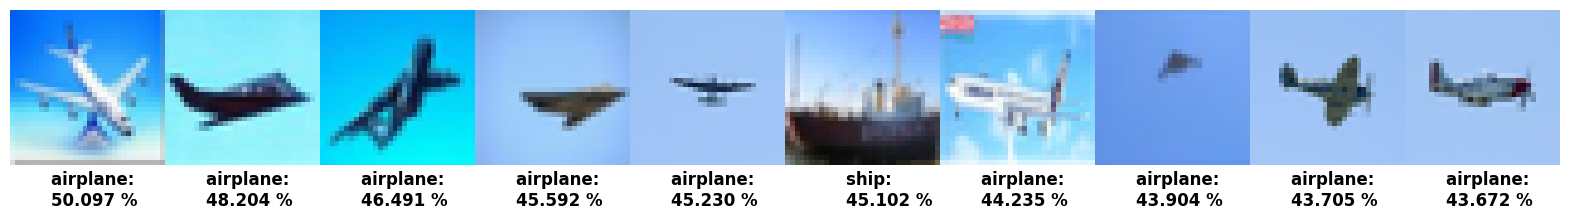

In [ ]:
show_the_best_predictions(model, X_test, y_test)

### Task Description:

You task of this exercise would be to improve the model's performance to achieve better results in image classification task. There is no need to change the preprocessing of the dataset. There are possible way how to improve the models performance:

1. Hyperparameter tunning - change the hyperparameters so that the model will perform better. You can experiment with the following:
 - *changing the number of neurons in the hidden layer*
 - *changing the number of hidden layers*
 - *changing the activation functions*
 - *changing the learning rate*
 - *changing the optimizer* - So far, we have used only Gradient descend as our optimizer, but Keras offers other algorithms that can perform better - check the documentation!
 - *changing the number of learning epochs*\
 - *changing the batch size*

2. Regularization techniques - There are several regularization techniques that can improve the model's performance:
 - *Dropout* -  In the Keras lib. you can add *dropout layer* into your Sequential model using the following command  *model.add(Dropout(p))* where *p* is an hyperparameter that controls dropout probabily, typical values are 0.1 - 0.5.
 - *L1, L2 regularization* - In keras the regularization is applied for selected layers, there is an example how to add l2 regularization to an layer (for more details check the documnetation):  *model.add(Dense(64, activation='relu', input_dim=100, kernel_regularizer=l2(0.01)))*
 - *Early stopping* -  In Keras, you can use the EarlyStopping callback to implement early stopping in your model. *early_stopping = EarlyStopping(monitor='val_loss', patience=3)*,  *model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])*


Try to make the highest testing accuracy possible. You can directly edit the code that is presented above, or you can copy everything into new cells. Please submit only the code with the best performance and briefly describe what approaches you have tried and what were the results

## Approach and Results for CIFAR-10

The initial feed-forward model was significantly improved by:

1. Adding a Conv2D Layer: (32 filters, 3x3 kernel, relu activation, same padding) to extract spatial features, followed by MaxPooling2D (2x2 pool) for dimensionality reduction. This replaced the initial Flatten layer.
2. Using relu: relu replaced sigmoid for computational efficiency and to avoid vanishing gradients.
3. Adding Dropout: For regularization to prevent overfitting.
4. Keeping the final Dense Layer: with 10 unit and a softmax activation.

Eight models were trained with early stopping, testing combinations of:

- learning_rate: [0.01, 0.005]
- optimizer_choice: ['sgd', 'adam']
- dropout_rate: [0.2, 0.3]

The best model used:

- learning_rate: 0.01
- optimizer_choice: 'sgd' (with momentum=0.9)
- dropout_rate: 0.2

This CNN configuration, with a single convolutional layer, max-pooling, and dropout, achieved the highest test accuracy, demonstrating the effectiveness of convolutional architectures and regularization. SGD with momentum balanced training stability and generalization.

In [17]:
import time
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm.keras import TqdmCallback
import numpy as np

In [18]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.3095 - loss: 1.9118 - val_accuracy: 0.5010 - val_loss: 1.4106
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5089 - loss: 1.3886 - val_accuracy: 0.5243 - val_loss: 1.3313
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5536 - loss: 1.2789 - val_accuracy: 0.5647 - val_loss: 1.2398
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5796 - loss: 1.2011 - val_accuracy: 0.5734 - val_loss: 1.2099
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.6015 - loss: 1.1558 - val_accuracy: 0.5923 - val_loss: 1.1708
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.6152 - loss: 1.1145 - val_accuracy: 0.6074 - val_loss: 1.1508
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.6232 - loss: 1.0952 - val_accuracy: 0.5937 - val_loss: 1.1674
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.6349 - loss: 1.0566 - 

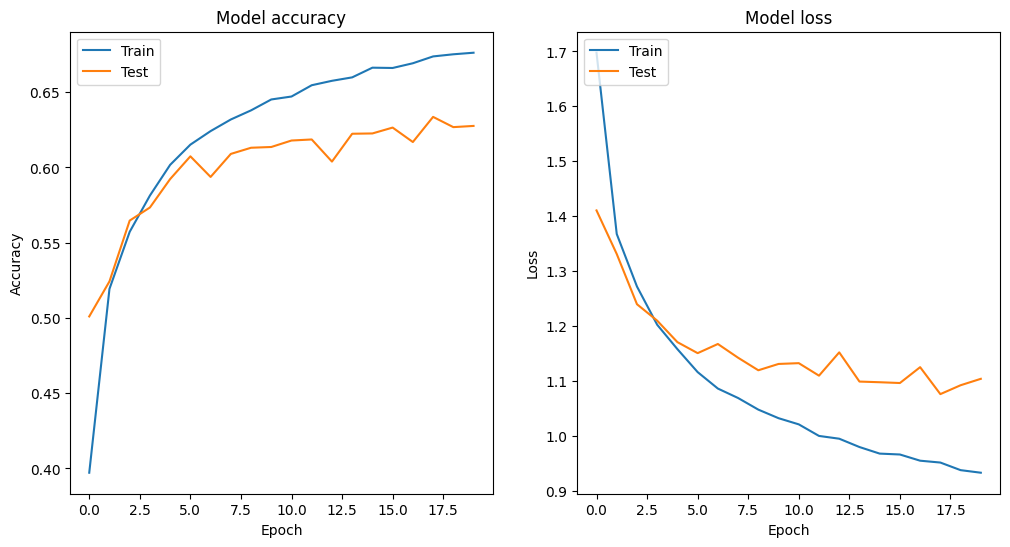

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


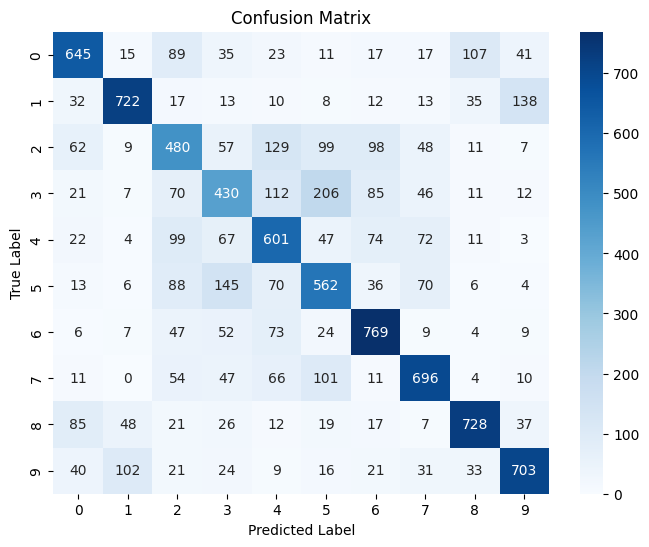

              precision    recall  f1-score   support

           0       0.69      0.65      0.67      1000
           1       0.78      0.72      0.75      1000
           2       0.49      0.48      0.48      1000
           3       0.48      0.43      0.45      1000
           4       0.54      0.60      0.57      1000
           5       0.51      0.56      0.54      1000
           6       0.67      0.77      0.72      1000
           7       0.69      0.70      0.69      1000
           8       0.77      0.73      0.75      1000
           9       0.73      0.70      0.72      1000

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.63     10000
weighted avg       0.64      0.63      0.63     10000



In [24]:
def build_model(learning_rate, optimizer_choice, dropout_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate) if optimizer_choice == 'adam' else SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

learning_rate = 0.01
optimizer_choice = 'sgd'
dropout_rate = 0.2
epochs = 20

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

model = build_model(learning_rate, optimizer_choice, dropout_rate)

history = model.fit(X_train, y_train, batch_size=64, epochs=epochs,
                    validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

elapsed_time = time.time() - start_time
print(f"Total time elapsed: {elapsed_time:.2f} seconds")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(10)]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

--- Statistics for Top Predictions ---
horse: 17/100 (17.00%)
truck: 12/100 (12.00%)
automobile: 35/100 (35.00%)
frog: 28/100 (28.00%)
airplane: 3/100 (3.00%)
ship: 5/100 (5.00%)
Average Confidence: 99.96%


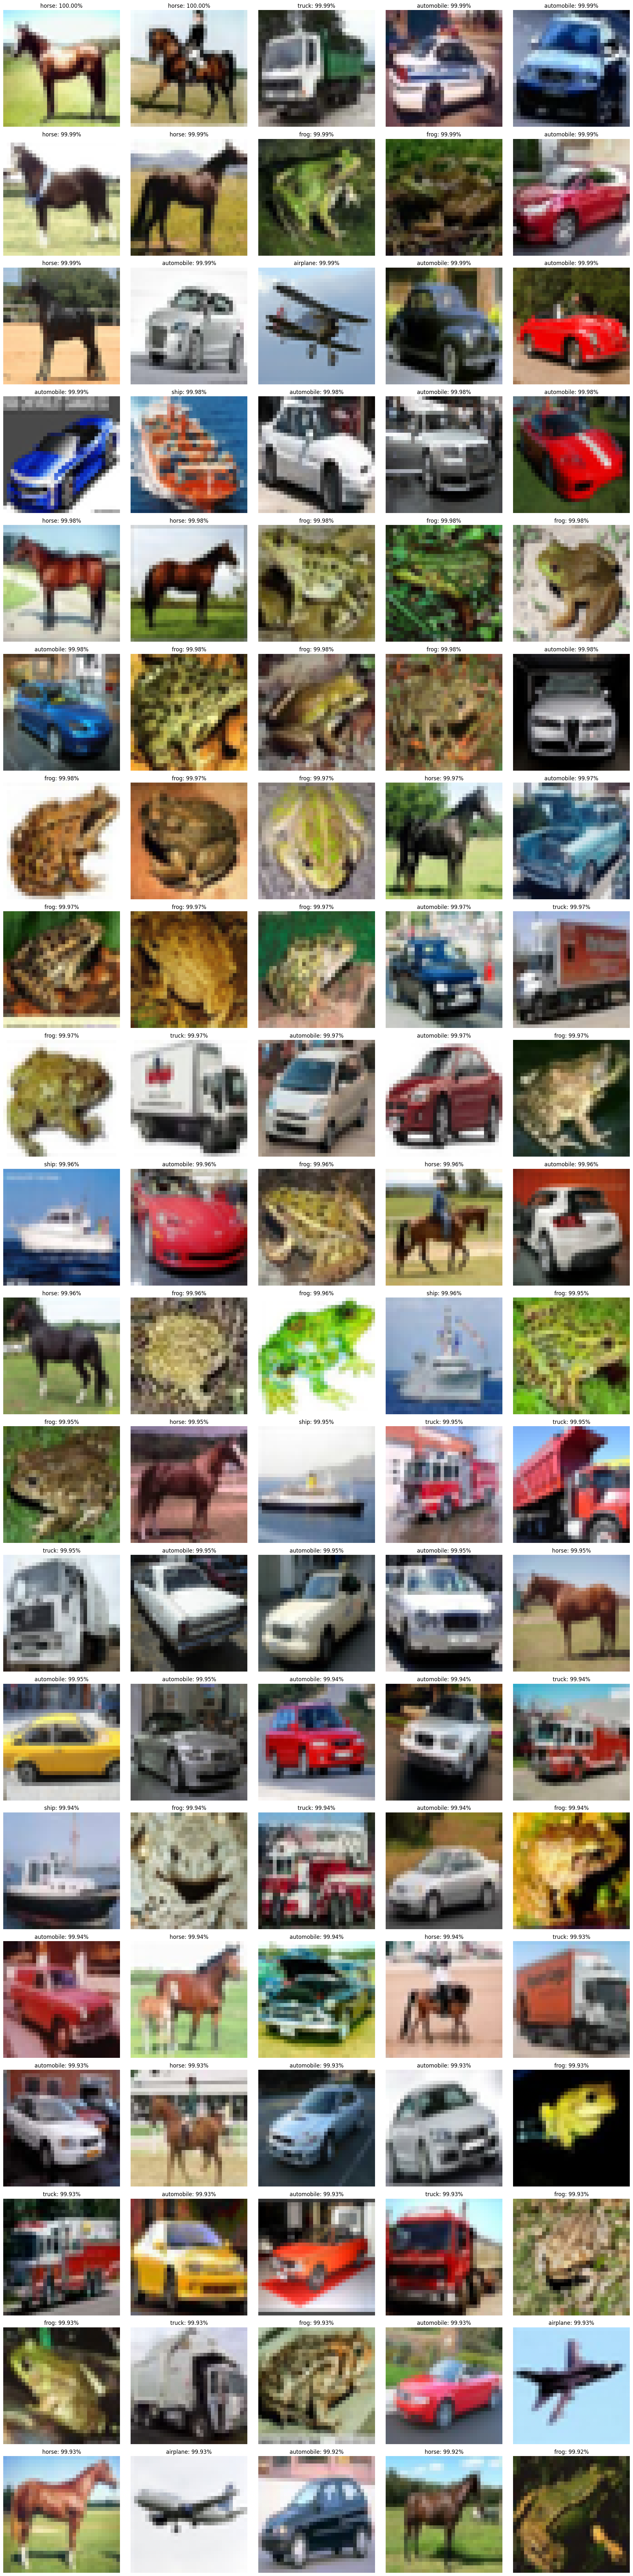

In [45]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from collections import Counter

def show_top_predictions(model_path: str, x_test: np.array, y_test: np.array, n_of_pred: int = 25, cols: int = 5) -> None:
    mapping = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
               5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

    model = load_model(model_path)
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    correct_indices = np.where(predicted_classes == y_test.flatten())[0]
    correct_predictions = predictions[correct_indices]
    correct_labels = y_test[correct_indices].flatten()
    correct_images = x_test[correct_indices]
    correct_probabilities = np.max(correct_predictions, axis=1)
    sorted_indices = np.argsort(correct_probabilities)[::-1]

    top_n_indices = sorted_indices[:n_of_pred]
    top_n_images = correct_images[top_n_indices]
    top_n_labels = correct_labels[top_n_indices]
    top_n_probabilities = correct_probabilities[top_n_indices]

    # Calculate statistics
    label_counts = Counter(top_n_labels)
    print("\n--- Statistics for Top Predictions ---")
    for label, count in label_counts.items():
        percentage = (count / n_of_pred) * 100
        print(f"{mapping[label]}: {count}/{n_of_pred} ({percentage:.2f}%)")
    avg_confidence = np.mean(top_n_probabilities) * 100
    print(f"Average Confidence: {avg_confidence:.2f}%")

    # Display the images in a grid
    rows = (n_of_pred + cols - 1) // cols
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i in range(n_of_pred):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(top_n_images[i])
        plt.title(f"{mapping[top_n_labels[i]]}: {top_n_probabilities[i] * 100:.2f}%")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    (_, _), (X_test, y_test) = cifar10.load_data()
    X_test = X_test.astype('float32') / 255.0
    model_path = "best_cifar10_model.h5"
    show_top_predictions(model_path, X_test, y_test, n_of_pred=100, cols=5)